In [2]:
import os
from dotenv import load_dotenv
from langchain_openai import OpenAI
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [3]:
import pandas as pd

df = pd.read_csv("cur_data.csv")
print(df.shape)
print(df.columns.tolist())

(72406, 15)
['CloudProvider', 'CloudProviderAccount', 'Date', 'Region', 'ResourceType', 'ResourceId', 'Costperday', 'CreatedDate', 'CreatedBy', 'IsRunning', 'Project', 'Environment', 'team', 'instance_type', 'ServiceType']


In [4]:
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine

engine = create_engine("sqlite:///cur_data.db")


In [5]:
db = SQLDatabase(engine=engine)
print(db.dialect)
print(db.get_usable_table_names())
print(db.run("SELECT * FROM cur_data WHERE project = 'ARK' LIMIT 10;"))

sqlite
['cur_data', 'titanic']
[(489986912819, 413304032703, 'canaan', 'arn:aws:elasticloadbalancing:us-east-1:413304032703:loadbalancer/a5df9041fc0c64bdc81f260098822c53', 'AWSDataTransfer', None, None, 3.3e-09, 1.639e-07, '2025-09-02T00:00:00Z/2025-09-03T00:00:00Z', "[('user_primary_app', 'ArkConnect'), ('user_function', 'ingress-nginx'), ('user_team', 'Managed IT'), ('user_secondary_app', 'ingress-nginx'), ('user_cloud_and_region', 'AWS\\xa0US\\xa0East-1'), ('user_environment', 'Production'), ('user_project', 'ARK')]", 0.0200999999999999, '2025-09-02', 'Managed IT', 'ARK', 'Production', 'ArkConnect', '2025-09'), (489986912819, 413304032703, 'canaan', 'arn:aws:elasticloadbalancing:us-east-1:413304032703:loadbalancer/a5df9041fc0c64bdc81f260098822c53', 'AWSDataTransfer', None, None, 2.687e-07, 1.34381e-05, '2025-09-01T00:00:00Z/2025-09-02T00:00:00Z', "[('user_primary_app', 'ArkConnect'), ('user_function', 'ingress-nginx'), ('user_team', 'Managed IT'), ('user_secondary_app', 'ingress-ngi

In [6]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [7]:
import getpass
import os

if not os.environ.get("MISTRAL_API_KEY"):
  os.environ["MISTRAL_API_KEY"] = getpass.getpass("Enter API key for Mistral AI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("mistral-large-latest", model_provider="mistralai")

In [8]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{{cur_data(management_account_id, usage_account_id, account_name, resource_id, aws_service, instance_type, aws_region, cost_amount, usage_quantity, time_period, resource_tags, cost_per_unit, usage_start_date, team, project, environment, primary_app, billing_period)}}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()


================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{cur_data(management_account_id, usage_account_id, account_name, resource_id, aws_service, instance_type, aws_region, cost_amount, usage_quantity, time_period, resource_tags, cost_per_unit, usage_start_date, team, proj

In [9]:
from typing_extensions import TypedDict
from langchain_ollama.chat_models import ChatOllama
from langchain_core.prompts import ChatPromptTemplate

# Assuming you already have query_prompt_template and llm initialized

class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: str

def write_query(state: State, hint: str | None = None):
    """Generate SQL query to fetch information, with optional hint for modification."""
    prompt_input = {
        "dialect": db.dialect,
        "top_k": 10,
        "table_info": db.get_table_info(),
        "input": state.get("question", ""),
    }

    if hint:
        prompt_input["hint"] = hint  # Add hint to template

    # Call your existing prompt template
    prompt = query_prompt_template.invoke(prompt_input)

    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)

    # Update state
    state["query"] = result["query"]
    return state




In [10]:
print(write_query({"question": "Which project is spending the most?"}))

{'question': 'Which project is spending the most?', 'query': 'SELECT project, SUM(cost_amount) AS total_cost FROM cur_data GROUP BY project ORDER BY total_cost DESC LIMIT 10;'}


In [11]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

# Initialize SQL tool globally
execute_query_tool = QuerySQLDatabaseTool(db=db)

def execute_query(state: State, max_retries=2):
    """
    Execute SQL query and handle empty results.
    If result is empty, refine the query using write_query + hint.
    """
    query = state["query"]

    for attempt in range(max_retries + 1):
        result = execute_query_tool.invoke(query)

        if result and result != "":
            state["query"] = query
            state["result"] = result
            return {"result": result}

        # Empty result → refine query
        print(f"Attempt {attempt+1}: Empty result, refining SQL query...")

        hint = (
            "The SQL query returned no results. "
            "Please slightly modify the SQL query to fetch relevant data"
            "without changing table or column names."
        )

        # Use write_query function with the hint
        state = write_query(state, hint=hint)
        query = state["query"]  # get new query

    print("No results found after retries.")
    return {"result": "No results found."}



In [12]:
execute_query({"query": "SELECT resource_id, aws_service, instance_type, aws_region, cost_amount, usage_quantity, time_period, resource_tags \nFROM cur_data \nWHERE cost_amount > 0 \n  AND aws_service IN ('Amazon Elastic Compute Cloud - Compute', 'Amazon Relational Database Service', 'Amazon ElastiCache', 'Amazon Redshift') \n  AND environment NOT LIKE '%prod%' \nORDER BY cost_amount DESC \nLIMIT 10;"})

Attempt 1: Empty result, refining SQL query...
Attempt 2: Empty result, refining SQL query...
Attempt 3: Empty result, refining SQL query...
No results found after retries.


{'result': 'No results found.'}

In [13]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user's question short and sweet.\n\n"
        "if no relevant information is found in the SQL result, say 'No relevant information found in the database.'\n\n"
        f"Question: {state['question']}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['result']}"
    
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [14]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

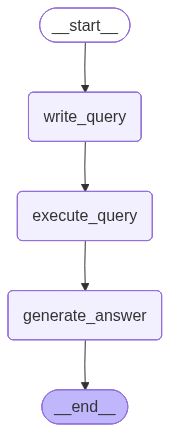

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
for step in graph.stream(
    {"question": "which resources can be terminated to save cost"}, stream_mode="updates"
):
    print(step)

{'write_query': {'question': 'which resources can be terminated to save cost', 'query': 'SELECT resource_id, aws_service, instance_type, aws_region, cost_amount, usage_quantity, time_period, team, project, environment \nFROM cur_data \nWHERE cost_amount > 0 \nORDER BY cost_amount DESC \nLIMIT 10;'}}
{'execute_query': {'result': "[('arn:aws:workspaces:us-east-1:832519233167:workspace/ws-69nndc8vm', 'AmazonWorkSpaces', None, 'us-east-1', 13.0, 1.0, '2025-09-01T00:00:00Z/2025-09-02T00:00:00Z', 'Managed\\xa0IT', 'Ark_Dev', 'Dev'), ('arn:aws:workspaces:us-east-1:832519233167:workspace/ws-1nv1q2ybg', 'AmazonWorkSpaces', None, 'us-east-1', 13.0, 1.0, '2025-09-01T00:00:00Z/2025-09-02T00:00:00Z', 'Managed\\xa0IT', 'Ark_Dev', 'Dev'), ('arn:aws:workspaces:us-east-1:832519233167:workspace/ws-1nv1q2ybg', 'AmazonWorkSpaces', None, 'us-east-1', 13.0, 1.0, '2025-10-01T00:00:00Z/2025-10-02T00:00:00Z', 'Managed\\xa0IT', 'Ark_Dev', 'Dev'), ('arn:aws:workspaces:us-east-1:832519233167:workspace/ws-69nndc8v

In [17]:
for step in graph.stream(
    {"question": "which project spends the most ?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'question': 'which project spends the most ?', 'query': 'SELECT project, SUM(cost_amount) AS total_cost FROM cur_data GROUP BY project ORDER BY total_cost DESC LIMIT 10;'}}
{'execute_query': {'result': "[(None, 3239.0088865869047), ('Ark_Dev', 1437.8471960070924), ('ARK', 647.5549714743992), ('ManagedIT', 118.92915676109978), ('ANM', 68.41660836650011), ('Apache Superset', 36.48405477179998), ('SuperSilo_2414', 23.143166767200015), ('silo', 0.4047320443999934), ('grace', 0.008863196099998201), ('OpenVAS', 0.0012951055999999)]"}}
{'generate_answer': {'answer': 'The project with the highest spending is **None** with a total cost of **$3,239.01**.'}}
